# A Network Tour of Data Science
## Final Project Winter 2016/17
### Matthaios Olma, Pavlos Nikolopoulos, Stefanos Skalistis
## Predicting success of GitHub projects

# Introduction

**Motivation:** A discouraging factor for adopting open source software (OSS), either for academical or industrial purposes, is the uncertainty of whether an OSS project will continue to have support by the community until the end of its use. 
As a result, most companies tend to avoid "risky" OSS projects that have been introduced recently and only rely on well established and supported projects. <br>
But, is there a better way? Could we predict the success of a project?

In this work, we focus on the **Github** projects. Our goal is to provide a method that is able to predict with high accuracy, whether a GitHub project will remain active after a given period of time T = 24 months, based on metadata corresponding to the first 12 months of its existence.

We believe that the predictability of a project's success is not trivial.
There are several factors contributing to this, such as human dynamics, project acceptance by the community and usefulness. 
Moreover, these factors change over time as the users and 
developers of OSS projects interact and affect each other.
Therefore, to achieve our goal, we will combine the immense historical data that GitHub.com offers through its API, with the classification techniques that were discussed in class.

In [1]:
# Import libraries

import os, json
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
import random
import sys
import re
import traceback

if sys.version_info[0] == 3:
    from urllib.request import urlopen
else:
    # Not Python 3 - today, it is most likely to be Python 2
    # But note that this might need an update when Python 4
    # might be around one day
    from urllib import urlopen
from pprint import pprint
from dateutil.parser import parse

# High-res visualization (but no rotation possible)
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')

import tensorflow as tf
import time
import collections

# Part 1: Data acquisition

As the main source of data, we use **Github.com**. We have collected meta-data for $3126$ projects which were acquired through Github Json-based API.

Along with the name of each project, the Github API also offers the following attributes:

* List of forks
* List of branches
* List of commits
* List of comments
* List of issue events

Each of the above lists of events (i.e. forks, commits,etc.) consists of a collection of events with various metadata related to the type of event. Then on, we will refer to all the above different types of events as "the events". 

For each type of event, we summed up the events on a monthly basis. The format of final dataset is a 5-dimensionsal time series for each project that contains the number of discrete events of each type and for every month of its lifespan. 

The downloaded dataset is loaded in Part 2. However, we present hereunder our code for the data extraction for completeness. 

Data-cleaning detail: Projects may have started on different dates and present a large number of events during their lifespan. Since the API does not provide the creation date of the project, we consider that the starting date is the date of the first event (commits, comments, etc). We also consider that all projects started at month 0.

In [2]:
# test function whether program has access rights to repository
def canAccessRepo(url):
    url = url+authurladd
    rawdata = urlopen(url)
    clean_data = json.loads(rawdata.read().decode('utf8'))
    return 'block' not in clean_data

# test function whether a given repository has at least one commit
def hasCommits(url):
    url = re.sub('{/sha}', '', url)
    url = url+authurladd
    rawdata = urlopen(url)
    clean_data = json.loads(rawdata.read().decode('utf8'))
    return 'message' not in clean_data

# function to extract from github.com json a given attribute
def fillup(x, what, remove, name_no, name_months):
    url = x[what]
    url = re.sub(remove, '', url)
    url = url+authurladd
    rawdata = urlopen(url)
    clean_data = json.loads(rawdata.read().decode('utf8'))

    month = -1
    i = 1;
    x[name_no] = []
    x[name_months] = []
    for y in clean_data:
        month_string = y['created_at']
        new_month = parse(month_string)
        if (new_month.month != month):
            if (month != -1):
                x[name_no].append(i);
                x[name_months].append((new_month.month, new_month.year));
            month = new_month.month
            i = 1;
        else:
            i = i + 1;
    return

# function to extract from github.com json specifically either a commit list or branch list
def fillup_commitAndBranch( x, what, remove, name_no, name_months, commitORbranch):
    url = x[what]
    url = re.sub(remove, '', url)
    url = url+authurladd
    rawdata = urlopen(url)
    clean_data = json.loads(rawdata.read().decode('utf8'))

    month = -1
    i = 1;
    x[name_no] = []
    x[name_months] = []
    for y in clean_data:
        if commitORbranch == 0: #commit
            month_string = y['commit']['author']['date']
        else: #branch
            # get to the commit:
            newurl = y['commit']['url'];
            if not hasCommits(newurl):
                continue;			
            newurl = newurl+authurladd		
            newrawdata = urlopen(newurl)
            newclean_data = json.loads(newrawdata.read().decode('utf8'))
            month_string = newclean_data['commit']['author']['date']
        new_month = parse(month_string)
        if (new_month.month != month):
            if (month != -1):
                x[name_no].append(i);
                x[name_months].append((new_month.month, new_month.year));
            month = new_month.month
            i = 1;
        else:
            i = i + 1;
    return

In [3]:
# extraction variables.

runCollection = False

lastid=0

# private authorization tokens to enable data download from github.com
#authurladd="?access_token=e2653e989dff889a14e823cada9458513da960d0"
authurladd="?access_token=1fbe7502659e73b263c4b2aa1655c59a307677bb"

# output filename
filename = 'data.json'

# fulllist variable stores all extracted data for a given project.
fulllist = []

In [4]:
if (runCollection):
    if os.path.isfile(filename):
        with open(filename) as f:
                fulllist = json.load(f)
        for x in fulllist:
            if (lastid < x['id']):
                lastid = x['id']


    projectCount = 0;
    numberOfProjects = 1000;
    while projectCount < numberOfProjects:
        try:
            url = "https://api.github.com/repositories" + authurladd + "&since="+str(lastid)
            print(url)
            response = urlopen(url)
            data = json.loads(response.read().decode('utf8'))

            if len(data) == 0:
                break;

            for x in data:
                if (projectCount > numberOfProjects):
                    break;

                print('printing: {0} {1}'.format(x['full_name'], x['id'], x['url']));

                if canAccessRepo(x['url']) == False or hasCommits(x['commits_url']) == False:
                    continue

                # ISSUE EVENTS
                fillup(x, 'forks_url', '', 'STATS_forks_no', 'STATS_forks_months');
                fillup(x, 'issue_events_url', '{/number}$', 'STATS_events_no', 'STATS_events_months');
                fillup(x, 'comments_url', '{/number}$', 'STATS_comment_no', 'STATS_comment_months');
                fillup_commitAndBranch(x, 'commits_url', '{/sha}$', 'STATS_commits_no', 'STATS_commits_months', 0);
                fillup_commitAndBranch(x, 'branches_url', '{/branch}$', 'STATS_branch_no', 'STATS_branch_months', 1);

                if (lastid < x['id']):
                    lastid = x['id']

                fulllist.append(x)
                projectCount += 1; 
        except:
            traceback.print_exc()
            break;

    with open(filename, mode='w') as feedsjson:
        json.dump(fulllist, feedsjson, indent=2, separators=(',', ': '))


# Part 2: Data exploration

In this part we explored the structure of the data in three steps:

(1) First, we set time T (in the code <tt>cutoff_proj_length</tt>) to 24 months. As denoted in our Introduction, T is the time, after which one would be interested in the activity of a project.<br>
Based on this value, we eliminated all projects which a lifespan lower than T. The cummulative histogram of the remaining projects is shown in the Fig. 1 below. There were 834 projects in the dataset that lasted more than 24 months and therefore constitute the useful data that we took into consideration. 

(2) To verify our intuition that the predictability of future events (i.e. forks, commits, comments, branches, issue events) is non-trivial, we have plotted the series of each type of event for all the projects as a function of time in Fig. 2. <br>
The result shows that the behavior of each project varies sharply after 24 months and does not follow any obvious trend. Hence, the use other prediction methods like linear regression or ARMA models may not be enough. Deep learning is perhaps the best way to go. 

(3) To also check whether T has been set correctly, in Fig. 3, we have plotted the average number of all types of events over all the projects for each month. The result shows that, on average, the projects that lasted more than 24 months tend to enter into a stationary regime after 20 months; which in turn verifies that T = 24 months is not only a reasonable in terms of software usage period, but also a meaningful in our dataset.  


In [28]:
#filename = "/home/olma/Work/Lectures/A_Network_Tour_of_Data_Science/Project/data/test.json"
filename = "./data/data_big.json"

# the minimum length of a project to be part of our dataset:
cutoff_proj_length = 24

# the number of months used for each dataset for training
dataset_training_length = 12

# a list that stores the length of each project
project_length_list = []

# data loaded from json file
projects_data = []

# a dictionary storing all data per project ({proj_name -> { date -> [no of commits, not of comments, etc.]} })
all_project_summary = {}

# indexes of statistics in all_project_summary dictionary.
event_attr = 0
comment_attr = 1
commit_attr = 2
branch_attr = 3
fork_attr = 4

In [6]:
# make tuple out of the data list ([month, year] -> (month,year))
def tupleise(date_list):
    tuple_list = []
    for date in date_list:
        tuple_list.append(tuple(reversed(date)));
    return tuple_list

def calc_project_length(project):
    # combine all months in dataset to find min and max date
    allmonths = set();
    set1 = set(tupleise(project['STATS_events_months']));
    set2 = set(tupleise(project['STATS_comment_months']));
    set3 = set(tupleise(project['STATS_commits_months']));
    set4 = set(tupleise(project['STATS_branch_months']));
    set5 = set(tupleise(project['STATS_forks_months']));
    allmonths = set1 | set2 | set3 | set4 | set5;
        
    # find the total number of months
    totalmonths = 0;
    first_month = 0;
    first_year = 0;
    if (len(allmonths) != 0):
        minmonth = min(allmonths)
        first_month = minmonth[1];
        first_year = minmonth[0];
        maxmonth = max(allmonths)
        # calculate number of months difference.
        yearsdiff = maxmonth[0] - minmonth[0] - 1
        monthsdiff = 13 - minmonth[1] + maxmonth[1]
        totalmonths = yearsdiff * 12 + monthsdiff
        
    # return the project length, the first month of the project and the first year of the project
    return totalmonths, first_month, first_year;

# fill for a given project a dictionary with all months it was in existence
def create_date_dictionary(project_stats_per_month, project_length, first_month, first_year):
    curmonth = first_month;
    curyear = first_year;
    for i in range(projectLength):
        tuple1 = (curyear, curmonth)
        project_stats_per_month[tuple1] = [0,0,0,0,0];
        curmonth = curmonth + 1;
        if (curmonth > 12):
            curyear = curyear + 1;
            curmonth = 1;

# fill for a given project its dictionary with values from the 
def fill_date_dictionary(project_stats_per_month, project, months, name, attr):
    allmonths = project[months];
    variables = project[name];
    for m,v in zip(allmonths, variables):
        project_stats_per_month[tuple(reversed(m))][attr] = v;

In [7]:
# open the input data file and store all data into the "all_project_summary" dictionary
with open(filename, 'r') as f:
    projects_data = json.load(f)
    
    for project in projects_data:
        project_stats_per_month = {}
        # get project length, its starting month and year
        projectLength, first_month, first_year = calc_project_length(project)
        
        # filter out projects with length more than "cutoff_proj_length" length 
        if (projectLength > cutoff_proj_length):                        
            # initialize a dictionary (date -> [no of commits, not of comments, etc.])
            create_date_dictionary(project_stats_per_month, projectLength, first_month, first_year)

            fill_date_dictionary(project_stats_per_month, project, 'STATS_events_months', 'STATS_events_no', event_attr)
            fill_date_dictionary(project_stats_per_month, project, 'STATS_comment_months', 'STATS_comment_no', comment_attr)
            fill_date_dictionary(project_stats_per_month, project, 'STATS_commits_months', 'STATS_commits_no', commit_attr)
            fill_date_dictionary(project_stats_per_month, project, 'STATS_branch_months', 'STATS_branch_no', branch_attr)
            fill_date_dictionary(project_stats_per_month, project, 'STATS_forks_months', 'STATS_forks_no', fork_attr)
            # add statistics into the project_summary
            
            if not project['full_name'] in all_project_summary:
                project_length_list.append(projectLength)            
                all_project_summary[project['full_name']] = project_stats_per_month;

**Plotting the data** <br>

In [8]:
def figure(num, data, yaxis, xaxis, title):
    plt.figure(num)
    plt.plot(np.asarray(data), hold=True)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.title(title)
    plt.grid(True)

def scatter(num, data, data_xaxis, yaxis, xaxis, title, colour):
    plt.figure(num)
    plt.scatter(np.asarray(data), np.asarray(data_xaxis), hold=True, color=colour)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.title(title)
    plt.grid(True)
    
def histogram(num, data, yaxis, xaxis, title):
    plt.figure(num)
    plt.hist(np.asarray(data), 100, histtype='step', cumulative=True)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.title(title)
    plt.grid(True)
    
def subfigure(fig, rows, column, row, data, xlabel, ylabel, xlimit):
    ax1 = fig.add_subplot(rows,column,row)
    ax1.plot(np.asarray(data))
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_xlim([0,xlimit])

Projects taken into consideration: 834


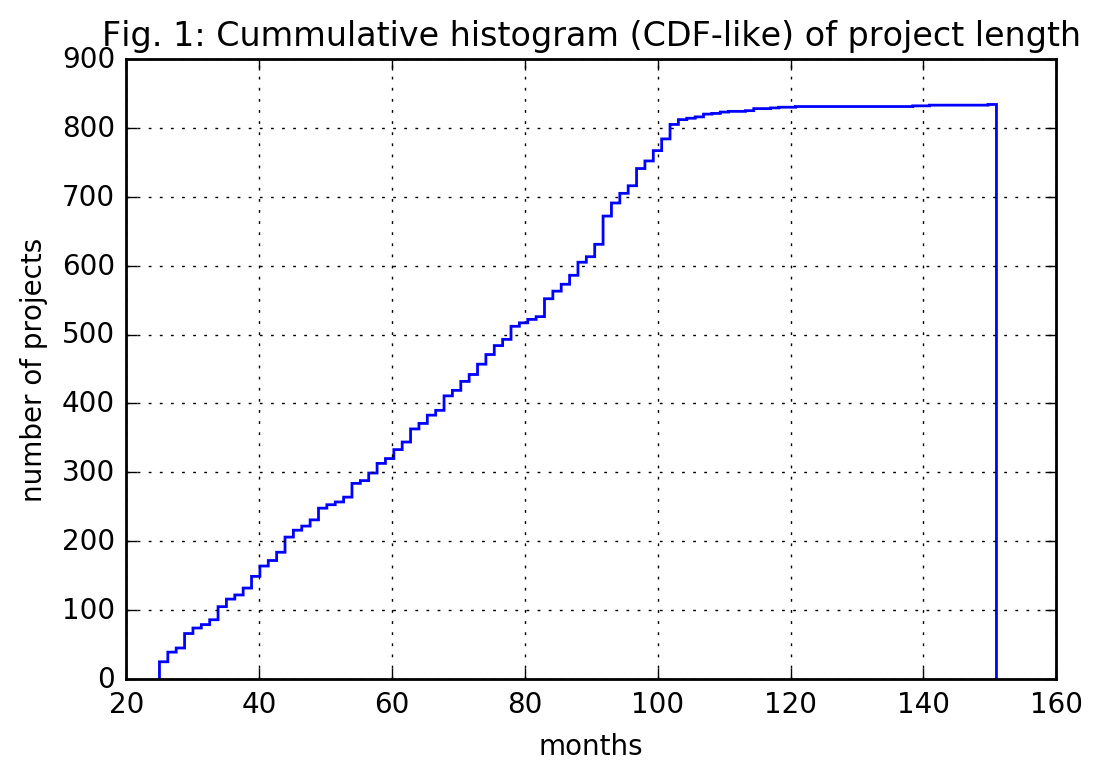

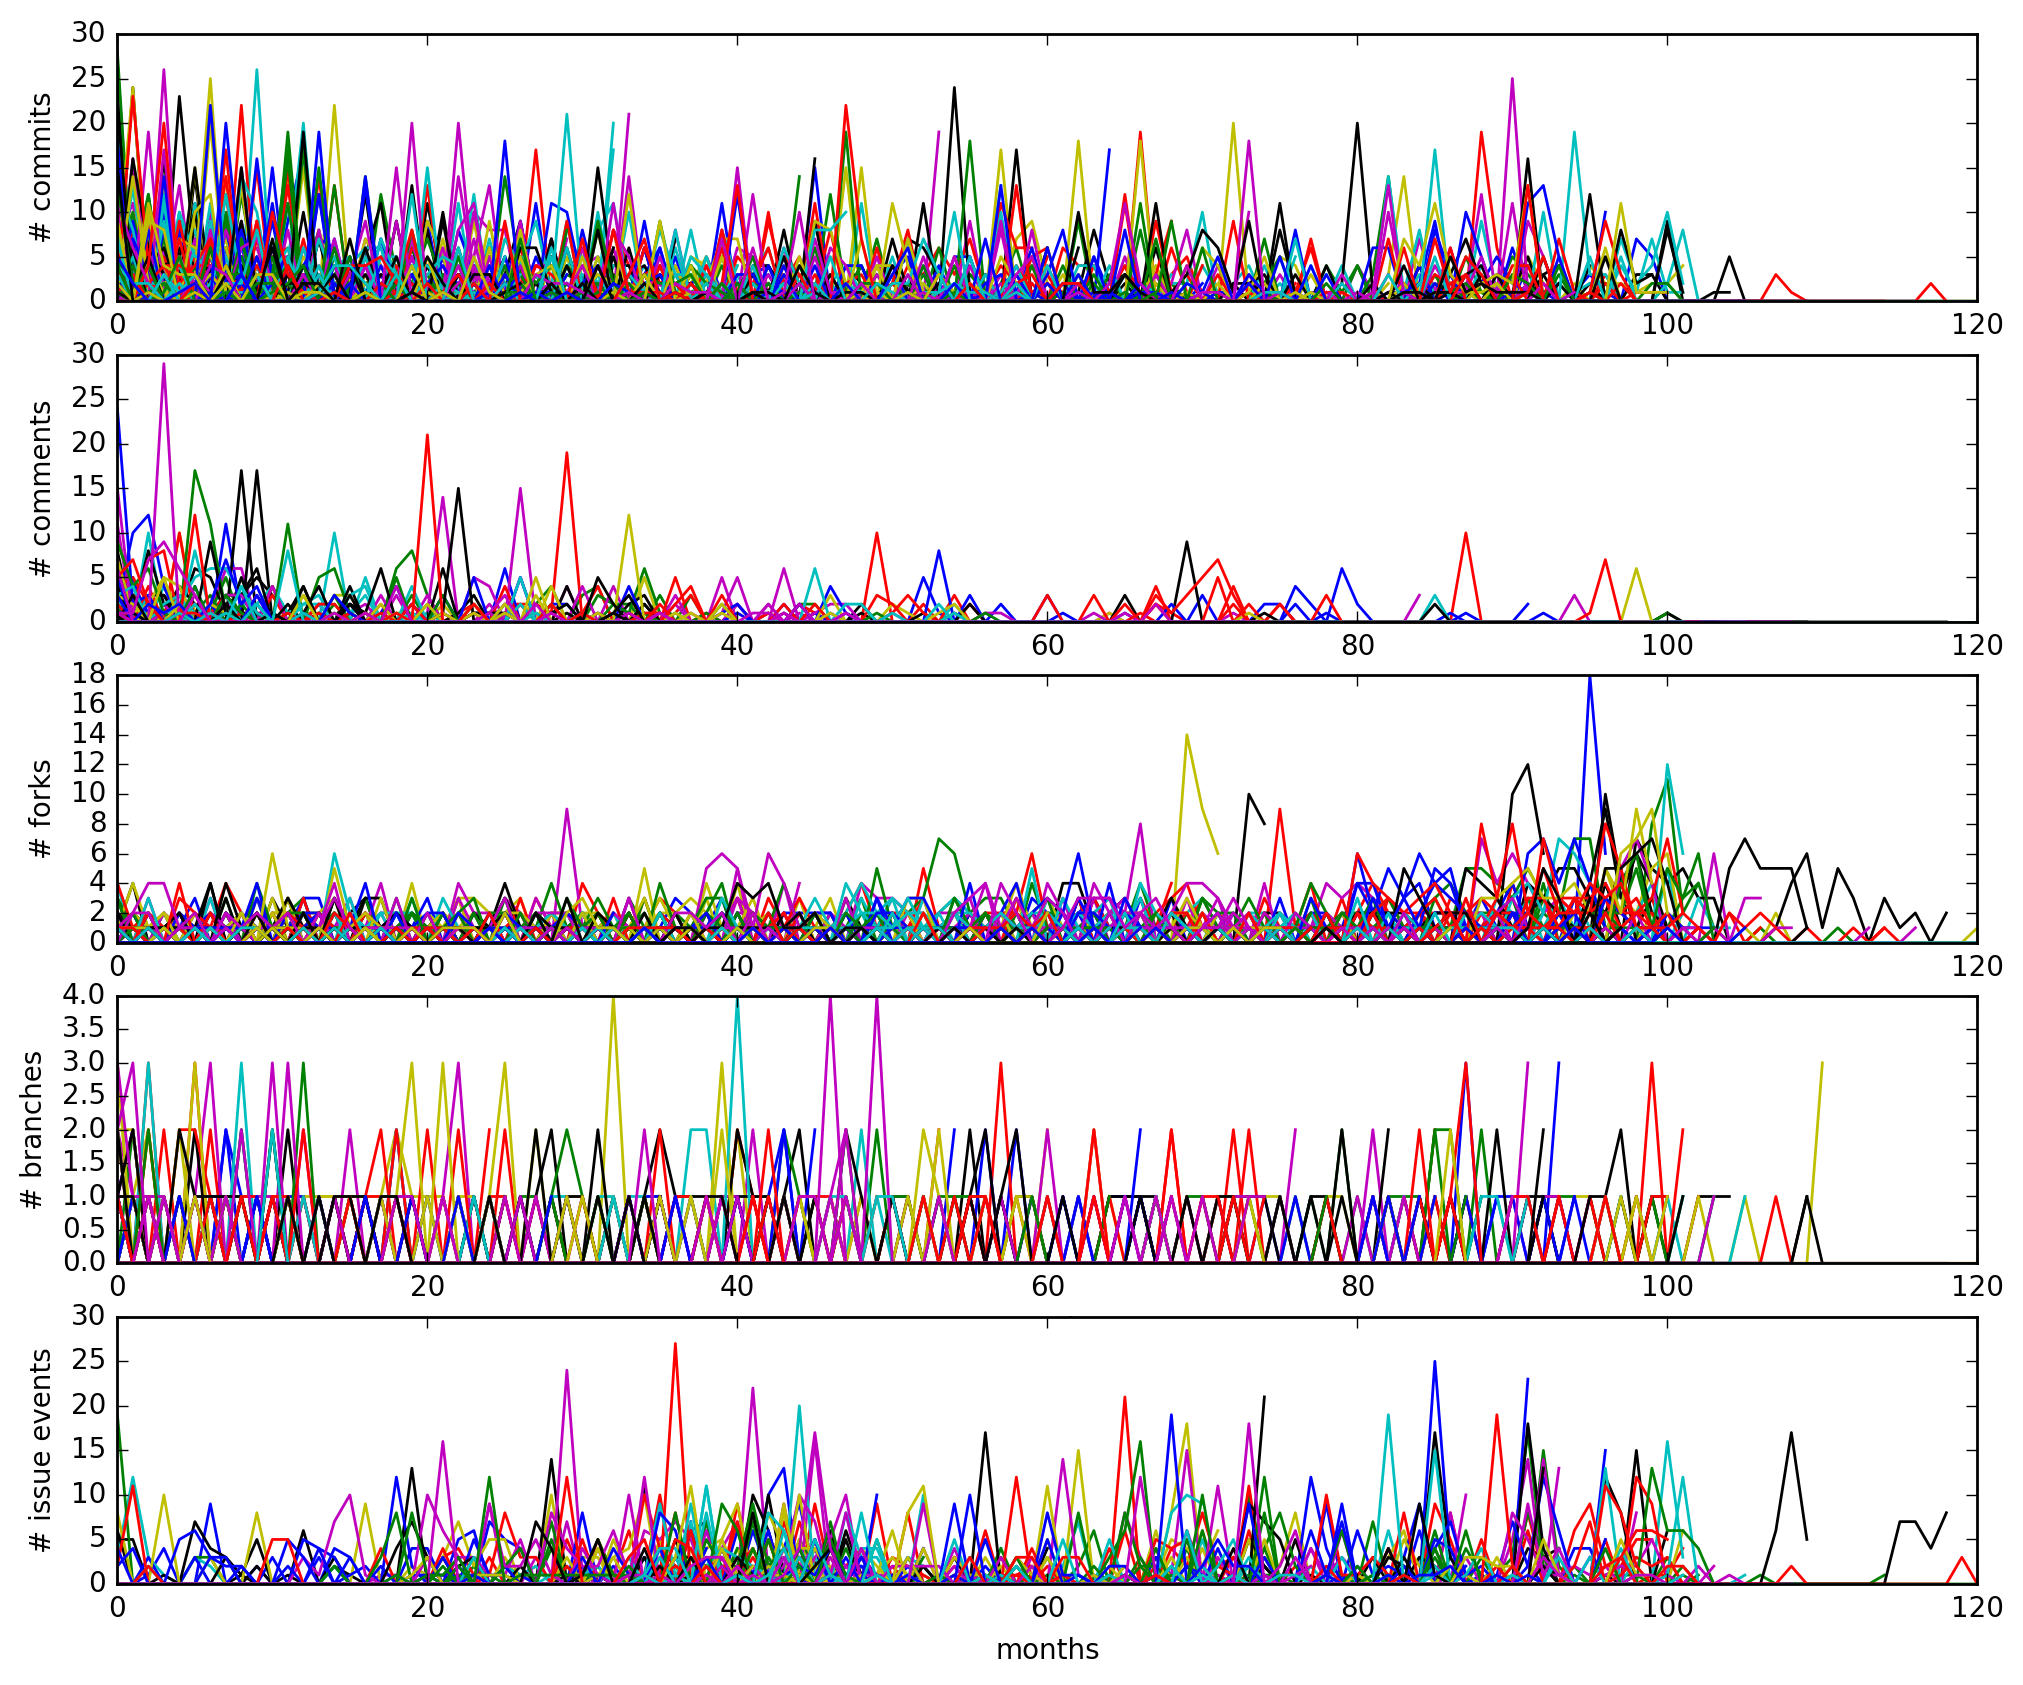

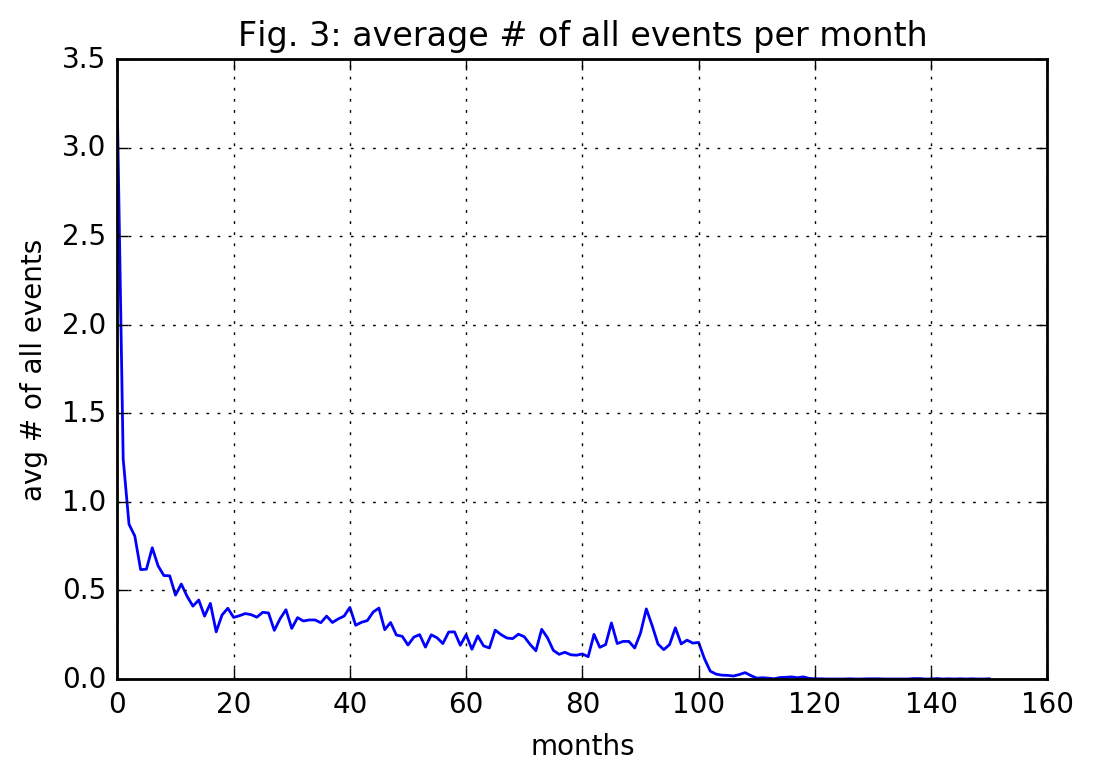

In [9]:
print('Projects taken into consideration: {0}'.format(len(all_project_summary)))
# the histogram of the data
histogram(0, project_length_list, 'number of projects', 'months', 'Fig. 1: Cummulative histogram (CDF-like) of project length')

fig = plt.figure(num=1, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

maxmonth = max(project_length_list)
allprojects_allevents = np.empty((len(all_project_summary),maxmonth,))
allprojects_allevents.fill(0);#np.NaN)
allprojects_allevents_list = []

index_project = 0
for project in all_project_summary:
    cur_project = all_project_summary[project];
    
    # creating lists storing all events for all projects per month (vertical cuts)
    commits = [];comments = [];forks = [];branches = [];events = [];
    allevents = np.empty((maxmonth,))
    allevents.fill(np.NaN)
    allevents_list = []
    index_month = 0;
    for months in sorted(cur_project):
        commits.append(cur_project[months][commit_attr])
        comments.append(cur_project[months][comment_attr])
        forks.append(cur_project[months][fork_attr])
        branches.append(cur_project[months][branch_attr])
        events.append(cur_project[months][event_attr])
        allprojects_allevents[index_project][index_month] = cur_project[months][event_attr]+cur_project[months][branch_attr]+cur_project[months][fork_attr]+cur_project[months][comment_attr]+cur_project[months][commit_attr]
        allevents_list.append(cur_project[months][event_attr]+cur_project[months][branch_attr]+cur_project[months][fork_attr]+cur_project[months][comment_attr]+cur_project[months][commit_attr])
        index_month += 1
    index_project += 1;
    allprojects_allevents_list.append(allevents_list)
    
    subfigure(fig, 5, 1, 1, commits, 'months', '# commits', 120)
    subfigure(fig, 5, 1, 2, comments, 'months', '# comments', 120)
    subfigure(fig, 5, 1, 3, forks, 'months', '# forks', 120)
    subfigure(fig, 5, 1, 4, branches, 'months', '# branches', 120)
    subfigure(fig, 5, 1, 5, events, 'months', '# issue events', 120)

figure(2, np.nanmean(allprojects_allevents, axis=0), 'avg # of all events', 'months', 'Fig. 3: average # of all events per month')

plt.figure(num=3, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
# plt.boxplot(allprojects_allevents_list, 0, '', 1, 0.95)
# plt.boxplot(allprojects_allevents, 0, '', 1, 0.95)
plt.show();

# Part 4: Producing the training set and Labeling the data

In this part we produce the training set that will be used in Part 5 and we label the data.

Our training dataset is the 5-dimemnsional time series of the 5 different types of events (commits, comments, branches, forks, issue events). The time series lasts for 12 months (which is given by variable <tt> dataset_training_length </tt> in our code.

For labeling the data, we took the following steps:

(1) We defined two classes of projects: the "successful" (denoted by a vector <tt>[1,0]</tt>) and the "unsuccessful" projects (denoted by a vector <tt>[0,1]</tt>).

(2) We considered the metric of a project's success to be the time-average rate $r$ of all aggregated events after time T. We chose the aggregate of events because any type of event  shows that the project is still active. And we chose the average rate because it accommodated any development process (e.g. agile or waterfall). Rate $r$ is <tt>avgOfAllEventsAfterCutOff</tt> in our code (see function <tt>create_proj_label</tt>). 

(3) Based on our metric, we defined a threshold named "<tt>event_requirement</tt>", which is the minimum rate of all aggregated events after time T that is required for a project to be considered successful. A project with average rate  of aggreagted events lower that <tt>event_requirement</tt> is considered "unsuccessful".<br>


 

**Choice of the <tt>event_requirement</tt> value:**

We picked <tt>event_requirement</tt> = 6 events/year, because of two reasons:

(a) We believe that a project presenting less than 1 event every two months is not any more an active project. 

(b) We saw a small change of curvature around value $r$ = 6 in Fig. 4. Fig. 4 depicts the average event rate $r$ (after time T) for each projects in an increasing order. <br> 
For a clear separation of the two classes, we would ideally like the curve $r(x)$ of Fig. 4 to present a discontinuity point $x_{0}$ and $\frac{1}{2}\left(r(x_{0}^{+}) - r(x_{0}^{-})\right) = 6$. However, we considered that this small change of curvature around value $r$ = 6 was enough to let us devide the projects into two classes according to that threshold. For a further check, we have produced the same figure using different subsets of the dataset. In all cases, we verified the change of curvature around $r$ = 6.  

Fig. 5 depicts the average event rate after time T for every project after the class separation: blue dots denote the successful projects, while red dots are for the unsuccessful ones.  

In [10]:
# minimum rate of events required after "cutoff_proj_length"
event_requirement = 6; # 6 events / year

# the labels (good/bad) of the projects
project_labels = []

# all project statistics (in a common array)
final_all_project_array = []

# current year
now_year = 2016
now_month = 12

In [11]:
def create_proj_label(project,commits,comments,forks,branches,events):
    # calculating stuff after cut-off...  
    numOfCommitsAfterCutOff = sum(commits[cutoff_proj_length:])
    numOfCommentsAfterCutOff = sum(comments[cutoff_proj_length:])
    numOfForksAfterCutOff = sum(forks[cutoff_proj_length:])
    numOfBranchesAfterCutOff = sum(branches[cutoff_proj_length:])
    numOfEventsAfterCutOff = sum(events[cutoff_proj_length:])
    sumOfAllEventsAfterCutOff = numOfCommitsAfterCutOff + numOfCommentsAfterCutOff + numOfForksAfterCutOff + numOfBranchesAfterCutOff + numOfEventsAfterCutOff
    avgOfAllEventsAfterCutOff = (sumOfAllEventsAfterCutOff/len(commits))*12;
    
    # for the subcase of project started in 2014
    if (min(project.keys())[0] == (now_year - cutoff_proj_length/12)) and (max(project.keys())[1] >= now_month - 3):
        return [1,0]
    
    # for the subcase of project started in january 2015
    if (min(project.keys())[0] == 2015) and (max(project.keys())[1] >= 1) and (max(project.keys())[0] == 2017):
        return [1,0]
    
    if avgOfAllEventsAfterCutOff > event_requirement:
        return [1,0], avgOfAllEventsAfterCutOff, sumOfAllEventsAfterCutOff
    else:
        return [0,1], avgOfAllEventsAfterCutOff, sumOfAllEventsAfterCutOff

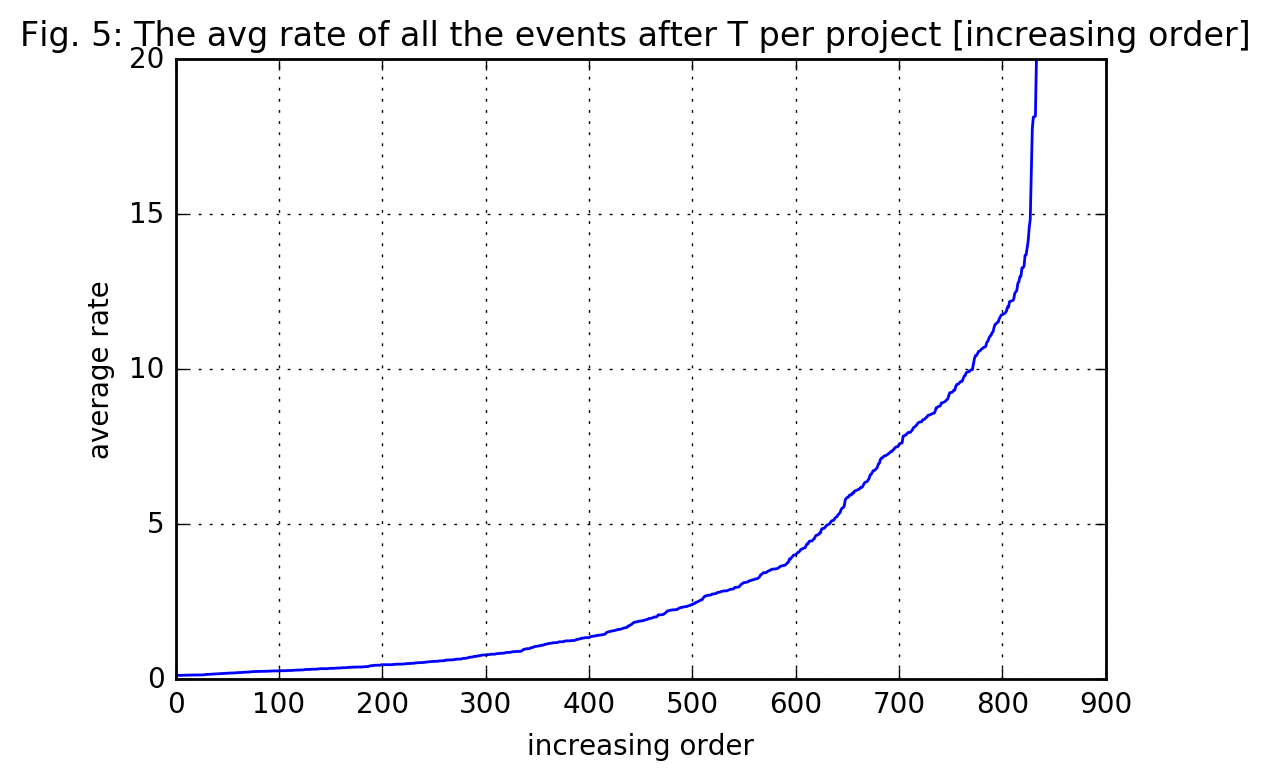

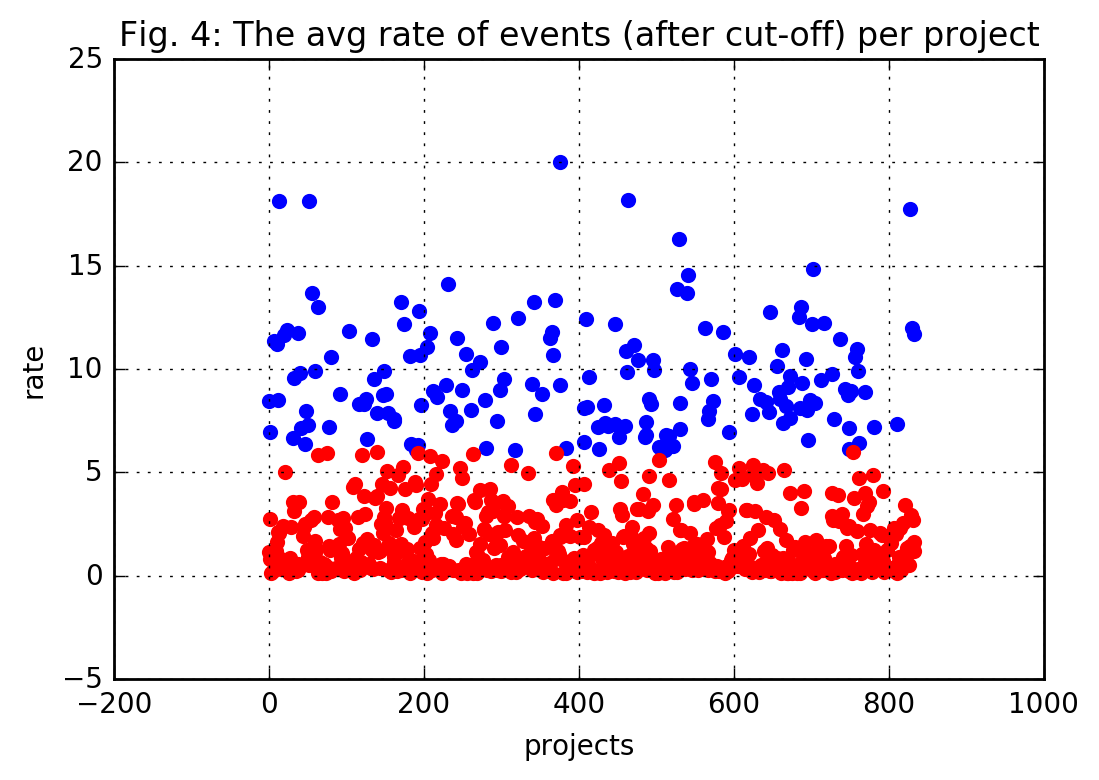

In [12]:
allAvgs = []
allSums = []

for project in all_project_summary:
    cur_project = all_project_summary[project];
    
    # creating lists storing all events for all projects per month (vertical cuts)
    commits = [];comments = [];forks = [];branches = [];events = []
    for months in sorted(cur_project):
        commits.append(cur_project[months][commit_attr])
        comments.append(cur_project[months][comment_attr])
        forks.append(cur_project[months][fork_attr])
        branches.append(cur_project[months][branch_attr])
        events.append(cur_project[months][event_attr])
    
    # cut the event datasets to contain only the months used for training and combine 
    project_train_all = []
    project_train_all.append(commits[:dataset_training_length])
    project_train_all.append(comments[:dataset_training_length])
    project_train_all.append(forks[:dataset_training_length])
    project_train_all.append(branches[:dataset_training_length])
    project_train_all.append(events[:dataset_training_length])
    
    # reduce the dimension
    finalnparray = np.reshape(np.asarray(project_train_all),[-1])
    
    # add current project statistics to a common array
    finalnparrayInList = finalnparray.tolist()
    final_all_project_array.append(finalnparrayInList)
    
    # create labels
    label, avg, summation = create_proj_label(cur_project, commits,comments,forks,branches,events)
    
    allAvgs.append(avg)
    allSums.append(summation)
   
    project_labels.append(label)

temp2 = [num for num in allAvgs if num <= event_requirement]
sample_yaxis_temp2 = random.sample(range(len(allAvgs)), len(temp2))

temp1 = [num for num in allAvgs if num > event_requirement]
sample_yaxis_temp1 = random.sample(range(len(allAvgs)), len(temp1))

figure(6, sorted(allAvgs), 'average rate', 'increasing order', 'Fig. 5: The avg rate of all the events after T per project [increasing order] ')
scatter(7, sorted(sample_yaxis_temp1), temp1, 'rate', 'projects', 'The avg rate of events (after cut-off) per project', 'b')
scatter(7, sorted(sample_yaxis_temp2), temp2, 'rate', 'projects', 'Fig. 4: The avg rate of events (after cut-off) per project', 'r')

plt.show()


# Part 5: Classifier models on tensorflow


In [13]:
training_datasize = 700
print(len(final_all_project_array))
test_datasize = len(final_all_project_array) - training_datasize

final_data_np_array = np.asarray(final_all_project_array)
final_label_np_array = np.asarray(project_labels)

train_data = final_data_np_array[:training_datasize].astype(np.float32)
train_labels = final_label_np_array[:training_datasize].astype(np.float32)

test_data = final_data_np_array[training_datasize:].astype(np.float32)
test_labels = final_label_np_array[training_datasize:].astype(np.float32)

print(train_data.shape)
print(train_labels.shape)

print(test_data.shape)
print(test_labels.shape)

834
(700, 60)
(700, 2)
(134, 60)
(134, 2)


** Model 1: A simple linear classifier **

In this part we define the following simple linear classifier model:
$$
y=\textrm{softmax}(xW+b),
$$
in which, we initialized the weights under a normal distibution with standard deviation 0.1 and bias = 0. We also avoided to use any regularization for the loss. 

This model serves as our benchmark for comparing against Model 2, which is a 2-layer neural network. 

Comment: Due to the similarity of the nature of the data contained into the training set (which are time series of different types of events) and the nature of the labeling function (which is based on the aggregated rate of all the events after time T), we expect that the linear classifier may have an overall good performance in terms of accuracy. Indeed the accuracy over both the training and the test sets is very high.    

In [23]:
# computational graph inputs
batch_size =50
d = train_data.shape[1]
nc = 2
x = tf.placeholder(tf.float32,[batch_size,d]); #print('x=',x,x.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())

# computational graph variables
initial = tf.truncated_normal([d,nc], stddev=0.1); W = tf.Variable(initial); #print('W=',W.get_shape())
b = tf.Variable(tf.zeros([nc],tf.float32)); #print('b=',b.get_shape())

# Construct CG / output value
y = tf.matmul(x, W); #print('y1=',y,y.get_shape())
y += b; #print('y2=',y,y.get_shape())
y = tf.nn.softmax(y); #print('y3=',y,y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))

reg_loss = tf.nn.l2_loss(W)
reg_loss += tf.nn.l2_loss(b)

reg_par = 1e-3
total_loss = cross_entropy #+ reg_par* reg_loss

# Update CG variables / backward pass
#train_step = tf.train.GradientDescentOptimizer(0.025).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [24]:
# Create test set 
idx = np.random.permutation(test_data.shape[0]) # rand permutation
idx = idx[:batch_size]
test_x, test_y = test_data[idx,:], test_labels[idx]
#print(idx.shape)

In [25]:
n = train_data.shape[0]
indices = collections.deque()

# Running Computational Graph
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(1001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) # rand permutation
    idx = [indices.popleft() for i in range(batch_size)] # extract n_batch data
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={x: batch_x, y_label: batch_y})
    
    # Run CG for testset
    if not i%50:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={x: test_x, y_label: test_y})
        print('test accuracy=',acc_test)

Instructions for updating:
Use `tf.global_variables_initializer` instead.

Iteration i= 0 , train accuracy= 0.32 , loss= 1.07516
test accuracy= 0.56

Iteration i= 50 , train accuracy= 0.66 , loss= 0.591796
test accuracy= 0.7

Iteration i= 100 , train accuracy= 0.84 , loss= 0.485606
test accuracy= 0.8

Iteration i= 150 , train accuracy= 0.88 , loss= 0.399259
test accuracy= 0.84

Iteration i= 200 , train accuracy= 0.8 , loss= 0.513276
test accuracy= 0.84

Iteration i= 250 , train accuracy= 0.9 , loss= 0.325242
test accuracy= 0.84

Iteration i= 300 , train accuracy= 0.78 , loss= 0.527815
test accuracy= 0.84

Iteration i= 350 , train accuracy= 0.84 , loss= 0.371915
test accuracy= 0.84

Iteration i= 400 , train accuracy= 0.94 , loss= 0.229956
test accuracy= 0.84

Iteration i= 450 , train accuracy= 0.8 , loss= 0.425766
test accuracy= 0.84

Iteration i= 500 , train accuracy= 0.8 , loss= 0.414242
test accuracy= 0.84

Iteration i= 550 , train accuracy= 0.88 , loss= 0.24708
test accuracy= 0.82



** Model 2: 2-layer neural network classifier:**
In this part, we define a 2-layer neural network:
$$
y=\textrm{softmax}(ReLU(xW_1+b_1)W_2+b_2)
$$

The first layer consists of 100 neurons.
We have also used L2 regularization term to prevent overfitting and Xavier's initilization for the weights. 

We observed that the improvement against the linear classifier is marginal, but still exists. This is mostly because of the very good performance of the simple linear classifier (Model 1). 

In [26]:
# Define computational graph (CG)
batch_size = 50         # batch size
d = train_data.shape[1]  # data dimensionality
nc = 2                  # number of classes
print(d)

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())

# 1st Fully Connected layer
nfc1 = 100
Wfc1 = tf.Variable(tf.truncated_normal([d,nfc1], stddev=tf.sqrt(6./tf.to_float(d+nfc1)) )); print('Wfc1=',Wfc1.get_shape())
bfc1 = tf.Variable(tf.zeros([nfc1])); #print('bfc1=',bfc1.get_shape())
y = tf.matmul(xin, Wfc1); #print('y1=',y,y.get_shape())
y += bfc1; #print('y2=',y,y.get_shape())

# ReLU activation
y = tf.nn.relu(y)

# 2nd Fully Connected layer
Wfc2 = tf.Variable(tf.truncated_normal([nfc1,nc], stddev=tf.sqrt(6./tf.to_float(nfc1+nc)) )); print('Wfc2=',Wfc2.get_shape())
bfc2 = tf.Variable(tf.zeros([nc])); #print('bfc2=',bfc2.get_shape())
y = tf.matmul(y, Wfc2); #print('y1b=',y,y.get_shape())
y += bfc2; #print('y2b=',y,y.get_shape())

# Softmax
y = tf.nn.softmax(y); #print('y3=',y,y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))

# L2 Regularization
reg_loss = 0.0
reg_loss += tf.nn.l2_loss(Wfc1)
reg_loss += tf.nn.l2_loss(bfc1)
reg_loss += tf.nn.l2_loss(Wfc2)
reg_loss += tf.nn.l2_loss(bfc2)
reg_par = 1e-3
total_loss = cross_entropy + reg_par* reg_loss

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.025).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

60
Wfc1= (60, 100)
Wfc2= (100, 2)


In [27]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(1001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%50:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_x, y_label: test_y})
        print('test accuracy=',acc_test)

Instructions for updating:
Use `tf.global_variables_initializer` instead.

Iteration i= 0 , train accuracy= 0.6 , loss= 0.888932
test accuracy= 0.6

Iteration i= 50 , train accuracy= 0.8 , loss= 0.557126
test accuracy= 0.82

Iteration i= 100 , train accuracy= 0.84 , loss= 0.38318
test accuracy= 0.84

Iteration i= 150 , train accuracy= 0.84 , loss= 0.423635
test accuracy= 0.86

Iteration i= 200 , train accuracy= 0.9 , loss= 0.342927
test accuracy= 0.88

Iteration i= 250 , train accuracy= 0.9 , loss= 0.266378
test accuracy= 0.86

Iteration i= 300 , train accuracy= 0.88 , loss= 0.312172
test accuracy= 0.84

Iteration i= 350 , train accuracy= 0.84 , loss= 0.38634
test accuracy= 0.86

Iteration i= 400 , train accuracy= 0.9 , loss= 0.281919
test accuracy= 0.86

Iteration i= 450 , train accuracy= 0.92 , loss= 0.25685
test accuracy= 0.86

Iteration i= 500 , train accuracy= 0.82 , loss= 0.364481
test accuracy= 0.86

Iteration i= 550 , train accuracy= 0.9 , loss= 0.269642
test accuracy= 0.86

It